In [33]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import selection_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# Modify the dataset by filling NaNs and dropping NO BIDS
mich_bids = pd.read_csv('panel.csv')
mich_bids[['Bid Per Unit','Highest']] = mich_bids[['Bid Per Unit','Highest']].fillna(0)

#add constant
mich_bids = sm.add_constant(mich_bids)

#units
unit_dummies = pd.get_dummies(mich_bids['Units'])
unit_dummies_name =  list(unit_dummies.columns)
mich_bids[unit_dummies_name]  = unit_dummies

#years
year_dummies = pd.get_dummies(mich_bids['month_year'].apply(lambda x : x[0:4]))
year_dummies_name = list(year_dummies.columns)
mich_bids[year_dummies_name]  = year_dummies


#interact stuff with units  'Highest',
x_names_raw = ['const', 'Appraised Value Per Unit','pot_bidders','Highest','acc_bidders']# 'Estimated Volume'] 
x_names_cov = []
for unit in ['MBF','Cords']: #unit_dummies_name:
    for x_name in x_names_raw:
        x_names_cov.append('%s*%s'%(x_name,unit))
        mich_bids['%s*%s'%(x_name,unit)] = mich_bids[x_name]*mich_bids[unit]
        
mich_bids['Estimated Volume*Appraised Value Per Unit']  = mich_bids['Estimated Volume']*mich_bids['Appraised Value Per Unit']

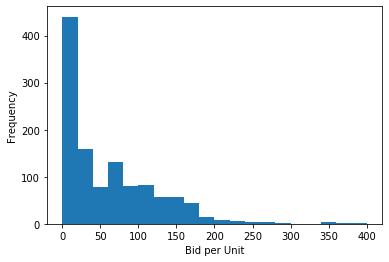

Index(['const', 'month_year', 'pot_bidders', 'Bidder Name', 'Sale #', 'Units',
       'Bid Per Unit', 'Highest', 'Estimated Volume',
       'Appraised Value Per Unit', 'Acres', 'Length(days)', 'Received',
       'Value', 'Volume', 'acc_bidders', 'Cords', 'MBF', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       'const*MBF', 'Appraised Value Per Unit*MBF', 'pot_bidders*MBF',
       'Highest*MBF', 'acc_bidders*MBF', 'const*Cords',
       'Appraised Value Per Unit*Cords', 'pot_bidders*Cords', 'Highest*Cords',
       'acc_bidders*Cords', 'Estimated Volume*Appraised Value Per Unit'],
      dtype='object')


In [42]:

plt.hist(mich_bids['Bid Per Unit'][mich_bids['Bid Per Unit']!=0],bins=20, range=(0,400))
plt.xlabel('Bid per Unit')
plt.ylabel('Frequency')
plt.savefig('bids_hist.png')
plt.show()

print(mich_bids.columns)

In [43]:
# Fit the model with ols = True
x_names_raw = ['const', 'Estimated Volume', 'Appraised Value Per Unit']
x_names = x_names_cov #(x_names_raw + unit_dummies_name[1:] )  #+ ['Estimated Volume*Appraised Value Per Unit']  
          #+ year_dummies_name[1:]) #

#different datasets
mich_bids_nozeros = mich_bids[mich_bids['Bid Per Unit']!=0]
mich_bids_cords = mich_bids[mich_bids['Units']!='Acres']
mich_bids_cordsnozeros = mich_bids[ (mich_bids['Units']!='Acres') & (mich_bids['Bid Per Unit']!=0) ]

#setup x/y for missing data models
x = mich_bids_cordsnozeros[x_names ].copy()
y = mich_bids_cordsnozeros['Bid Per Unit']

ols_model = sm.OLS(y,x).fit()
print(ols_model.summary())
print(ols_model.summary().as_latex())

#setup x/y for missing data models
x = mich_bids_cords[x_names ].copy()
y = mich_bids_cords['Bid Per Unit']

# seems like year fixed effects are not predictive
# also seems like estimated volume doesn't matter
# seems like apraised value is the only thing
# only like 13 observations with acres

                            OLS Regression Results                            
Dep. Variable:           Bid Per Unit   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     267.9
Date:                Thu, 20 May 2021   Prob (F-statistic):          3.93e-276
Time:                        13:28:49   Log-Likelihood:                -5882.5
No. Observations:                1172   AIC:                         1.179e+04
Df Residuals:                    1162   BIC:                         1.184e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const*MBF   

In [44]:
tobit_model = selection_tests.Tobit(y,x, cc=True).fit()
print(tobit_model.summary(title='OLS CC'))
print('\n')
print(tobit_model.summary(title='OLS CC').as_latex())

Optimization terminated successfully.
         Current function value: 2.000345
         Iterations: 323
         Function evaluations: 508
                                    OLS CC                                    
Dep. Variable:           Bid Per Unit   Log-Likelihood:                -6825.2
Model:                          Tobit   AIC:                         1.367e+04
Method:            Maximum Likelihood   BIC:                         1.373e+04
Date:                Thu, 20 May 2021                                         
Time:                        13:28:50                                         
No. Observations:                3412                                         
Df Residuals:                    3402                                         
Df Model:                           9                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [45]:
# Fit the model with ols = False
tobit_model = selection_tests.Tobit(y,x).fit()

print(tobit_model.summary())
print('\n')
print(tobit_model.summary().as_latex())

                                Tobit Results                                 
Dep. Variable:           Bid Per Unit   Log-Likelihood:                -8018.0
Model:                          Tobit   AIC:                         1.606e+04
Method:            Maximum Likelihood   BIC:                         1.612e+04
Date:                Thu, 20 May 2021                                         
Time:                        13:28:51                                         
No. Observations:                3412                                         
Df Residuals:                    3402                                         
Df Model:                           9                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const*MBF                        -24.6359     10.635     -2.316      0.021     -45.480     

/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [46]:
# Fit the regular test model
regular_test_model = selection_tests.regular_test(y,x,selection_tests.setup_test)
regular_test_model

/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


regular: test, llr, omega ----
-7.1219646574254565 -1213.5593232252827 2.917136059173132
---- 


(2, -7.1219646574254565)

In [47]:
# Fit the bootstrap test model
bootstrap_test_model = selection_tests.bootstrap_test(y,x,selection_tests.setup_test, trials=100)
bootstrap_test_model

/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


V ----
(33.03136142173574+1.3505047098617301e-20j)
----
---- bootstrap: llr, omega ----
(-1180.527961803547+1.3505047098617301e-20j) (170.39670675141713+0j)
----


(2,
 (-25.30750591631462+2.476455426354445e-22j),
 (-2.8288014481144828+4.8485540096092306e-23j))

In [48]:
selection_tests.test_table(y,x,selection_tests.setup_test, trials=100)

/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


V ----
(33.03136142173574+1.3505047098617301e-20j)
----
---- bootstrap: llr, omega ----
(-1180.527961803547+1.3505047098617301e-20j) (170.39670675141713+0j)
----


/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


regular: test, llr, omega ----
-7.1219646574254565 -1213.5593232252827 2.917136059173132
---- 
\begin{center}
\begin{tabular}{cccc}
\toprule
\textbf{Version} & \textbf{Result} & \textbf{Stat} & \textbf{95 \% CI} \\ \midrule
Bootstrap & H2 & -- & [-26.218, -2.492] \\
Classical & H2 & -7.122 & [1.959, 1.959] \\
\bottomrule
\end{tabular}
\end{center}
